In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
group1 = pd.read_csv('DataPaper/group1.csv')

In [3]:
group1.head()

,user,Activity,hr,Cortisol_before_sleep,Cortisol_wake_up,Melatonin_before_sleep,Melatonin_wake_up,Pittsburgh,Efficiency,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,class
0,user_9,3.0,147.783251,0.025968,0.080560,5.593342e-09,7.385992e-09,9.0,91.75,578,49,4,high_state_anxiety
1,user_19,7.0,78.740157,0.012017,0.062891,1.629907e-09,1.495653e-09,4.0,74.07,340,118,44,low_state_anxiety
2,user_20,7.0,78.947368,0.013820,0.047007,4.885483e-09,4.638534e-09,5.0,88.07,384,52,12,high_state_anxiety
3,user_19,2.0,99.667774,0.012017,0.062891,1.629907e-09,1.495653e-09,4.0,74.07,340,118,44,low_state_anxiety
4,user_3,8.0,78.226858,0.012142,0.043799,5.714439e-09,3.603324e-09,8.0,79.23,351,89,16,low_state_anxiety


In [4]:
# group1 = group1.drop(['time_seconds', 'time_radians','STAI1','STAI2','day','hour','ibi_s'],axis=1).dropna()
group1 = group1.sample(frac=1).reset_index(drop=True)

In [5]:
group1 = group1.groupby('user').head(150)

In [6]:
high_state_anxiety = group1[group1['class'] == 'high_state_anxiety']
low_state_anxiety = group1[group1['class'] == 'low_state_anxiety']

high_state_anxiety_users = high_state_anxiety['user'].unique()
low_state_anxiety_users = low_state_anxiety['user'].unique()

In [7]:
min_users = min(len(high_state_anxiety_users), len(low_state_anxiety_users))

In [8]:
high_state_anxiety_users_selected = pd.Series(
    high_state_anxiety_users).sample(n=min_users, random_state=42).values
low_state_anxiety_users_selected = pd.Series(
    low_state_anxiety_users).sample(n=min_users, random_state=42).values

In [9]:
high_state_anxiety_selected = high_state_anxiety[high_state_anxiety['user'].isin(
    high_state_anxiety_users_selected)]
low_state_anxiety_selected = low_state_anxiety[low_state_anxiety['user'].isin(
    low_state_anxiety_users_selected)]

In [10]:
high_state_anxiety_selected = high_state_anxiety_selected.sample(
    frac=1, random_state=42).reset_index(drop=True)
low_state_anxiety_selected = low_state_anxiety_selected.sample(
    frac=1, random_state=42).reset_index(drop=True)

In [11]:
high_state_anxiety_selected

,user,Activity,hr,Cortisol_before_sleep,Cortisol_wake_up,Melatonin_before_sleep,Melatonin_wake_up,Pittsburgh,Efficiency,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,class
0,user_18,7.0,66.225166,0.015166,0.068494,1.384661e-08,5.730512e-09,5.0,84.36,302,53,9,high_state_anxiety
1,user_22,6.0,67.264574,0.018414,0.033249,2.728199e-09,8.283802e-10,5.0,84.92,304,51,21,high_state_anxiety
2,user_18,2.0,72.376357,0.015166,0.068494,1.384661e-08,5.730512e-09,5.0,84.36,302,53,9,high_state_anxiety
3,user_18,7.0,77.021823,0.015166,0.068494,1.384661e-08,5.730512e-09,5.0,84.36,302,53,9,high_state_anxiety
4,user_1,10.0,90.771558,0.034137,0.077939,1.738385e-08,6.747893e-09,5.0,87.27,144,21,9,high_state_anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,user_22,3.0,60.362173,0.018414,0.033249,2.728199e-09,8.283802e-10,5.0,84.92,304,51,21,high_state_anxiety
896,user_1,6.0,103.092784,0.034137,0.077939,1.738385e-08,6.747893e-09,5.0,87.27,144,21,9,high_state_anxiety
897,user_22,3.0,90.497738,0.018414,0.033249,2.728199e-09,8.283802e-10,5.0,84.92,304,51,21,high_state_anxiety
898,user_10,4.0,99.833611,0.037046,0.019659,8.669611e-09,2.573795e-09,4.0,75.08,247,78,13,high_state_anxiety


# Task 1: High state anxiety selected

In [12]:
X = high_state_anxiety_selected.drop(columns=['class', 'user','hr'])
y = high_state_anxiety_selected['hr']

In [13]:
X_train, X_test, y_train, y_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(y)*0.8)], y[int(len(y)*0.8):]

In [14]:
print(f"Training set :\n{y_train.shape}")
print(f"Test set :\n{y_test.shape}")

Training set :
(720,)
Test set :
(180,)


In [15]:
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(eval_metric='mlogloss'),
    'DecisionTree': DecisionTreeRegressor()
}

In [16]:
pipelines = {}
shap_values_dict = {}
explainers = {}

In [17]:
for model_name, model in models.items():
    pipelines[model_name] = Pipeline([
        ('regressor', model)
    ])
    print(f"Training {model_name}...")
    pipelines[model_name].fit(X_train, y_train)

    if model_name == 'XGBoost':
        explainer = shap.Explainer(
            pipelines[model_name].named_steps['regressor'])
    else:
        explainer = shap.TreeExplainer(
            pipelines[model_name].named_steps['regressor'])

    explainers[model_name] = explainer
    shap_values = explainer.shap_values(X_test)
    shap_values_dict[model_name] = shap_values

Training RandomForest...
Training XGBoost...
Training DecisionTree...


In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
    'RandomForest': {
        'regressor__n_estimators': [100, 200, 300, 500],
        'regressor__max_depth': [None, 10, 20, 30, 50],
        'regressor__min_samples_split': [2, 5, 10, 15],
        'regressor__min_samples_leaf': [1, 2, 4, 8],
        'regressor__max_features': ['sqrt', 'log2', 0.5], 
        'regressor__bootstrap': [True, False],
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200, 300, 500],
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'regressor__max_depth': [3, 6, 9, 12],
        'regressor__subsample': [0.6, 0.8, 1.0],
        'regressor__colsample_bytree': [0.6, 0.8, 1.0],
        'regressor__gamma': [0, 0.1, 0.2, 0.3],
        'regressor__lambda': [1, 1.5, 2],
    },
    'DecisionTree': {
        'regressor__max_depth': [None, 10, 20, 30, 50],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4, 8],
        'regressor__max_features': ['sqrt', 'log2', 0.5], 
    }
}


best_estimators = {}

for model_name, model in models.items():
    print(f"Performing randomized search for {model_name}...")

    random_search = RandomizedSearchCV(
        estimator=pipelines[model_name],
        param_distributions=param_grid[model_name],
        n_iter=20,  
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=np.random.randint(1, 1000), 
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    best_estimators[model_name] = random_search.best_estimator_

    print(f"Best parameters for {model_name}: {random_search.best_params_}")

Performing randomized search for RandomForest...
Best parameters for RandomForest: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': None, 'regressor__bootstrap': True}
Performing randomized search for XGBoost...
Best parameters for XGBoost: {'regressor__subsample': 0.6, 'regressor__n_estimators': 100, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05, 'regressor__lambda': 1.5, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 0.6}
Performing randomized search for DecisionTree...
Best parameters for DecisionTree: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}


In [28]:
grid_search_results = []

for model_name, model in models.items():
    print(f"Performing randomized search for {model_name}...")

    random_search = RandomizedSearchCV(
        estimator=pipelines[model_name],
        param_distributions=param_grid[model_name],
        n_iter=20,  
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=np.random.randint(1, 1000), 
        n_jobs=-1,
        return_train_score=True,
        error_score=np.nan  
    )

    random_search.fit(X_train, y_train)

    results = random_search.cv_results_
    params = results['params']
    mean_test_score = results['mean_test_score']
    std_test_score = results['std_test_score']
    mean_r2 = results.get('mean_test_score', None)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)

    best_estimators[model_name] = best_model

    for i in range(len(params)):
        formatted_hyperparams = list(params[i].values())  
        grid_search_results.append({
            "Model": model_name,
            "Hyperparameters": formatted_hyperparams,
            "R² Test": f"{r2_test:.3f} ± {np.std(mean_r2):.3f}" if mean_r2 is not None else "N/A",
            "MSE Test": f"{mse_test:.3f} ± {std_test_score[i]:.3f}"
        })

grid_search_df = pd.DataFrame(grid_search_results)

Performing randomized search for RandomForest...
Performing randomized search for XGBoost...
Performing randomized search for DecisionTree...


In [36]:
grid_search_df.groupby('Model').head()

,Model,Hyperparameters,R² Test,MSE Test
0,RandomForest,"[300, 15, 8, 0.5, None, True]",0.494 ± 5.070,111.911 ± 46.710
1,RandomForest,"[500, 15, 2, log2, None, True]",0.494 ± 5.070,111.911 ± 45.179
2,RandomForest,"[500, 15, 2, 0.5, 10, False]",0.494 ± 5.070,111.911 ± 51.231
3,RandomForest,"[500, 10, 2, sqrt, 20, True]",0.494 ± 5.070,111.911 ± 44.834
4,RandomForest,"[100, 2, 8, 0.5, 50, False]",0.494 ± 5.070,111.911 ± 47.787
20,XGBoost,"[1.0, 100, 6, 0.01, 1.5, 0.3, 0.8]",0.529 ± 7.012,104.095 ± 50.320
21,XGBoost,"[0.6, 500, 3, 0.05, 2, 0.3, 1.0]",0.529 ± 7.012,104.095 ± 51.470
22,XGBoost,"[0.8, 500, 3, 0.01, 2, 0.1, 0.6]",0.529 ± 7.012,104.095 ± 46.595
23,XGBoost,"[0.8, 500, 3, 0.05, 1, 0.1, 0.8]",0.529 ± 7.012,104.095 ± 51.991
24,XGBoost,"[0.6, 200, 6, 0.1, 1.5, 0.3, 1.0]",0.529 ± 7.012,104.095 ± 52.023


In [30]:
for model_name, best_estimator in best_estimators.items():
    print(f"Training {model_name} with best parameters...")
    best_estimator.fit(X_train, y_train)
    pipelines[model_name] = best_estimator

    if model_name == 'XGBoost':
        explainer = shap.Explainer(best_estimator.named_steps['regressor'])
    else:
        explainer = shap.TreeExplainer(best_estimator.named_steps['regressor'])

    explainers[model_name] = explainer
    shap_values = explainer.shap_values(X_test)
    shap_values_dict[model_name] = shap_values

Training RandomForest with best parameters...
Training XGBoost with best parameters...
Training DecisionTree with best parameters...


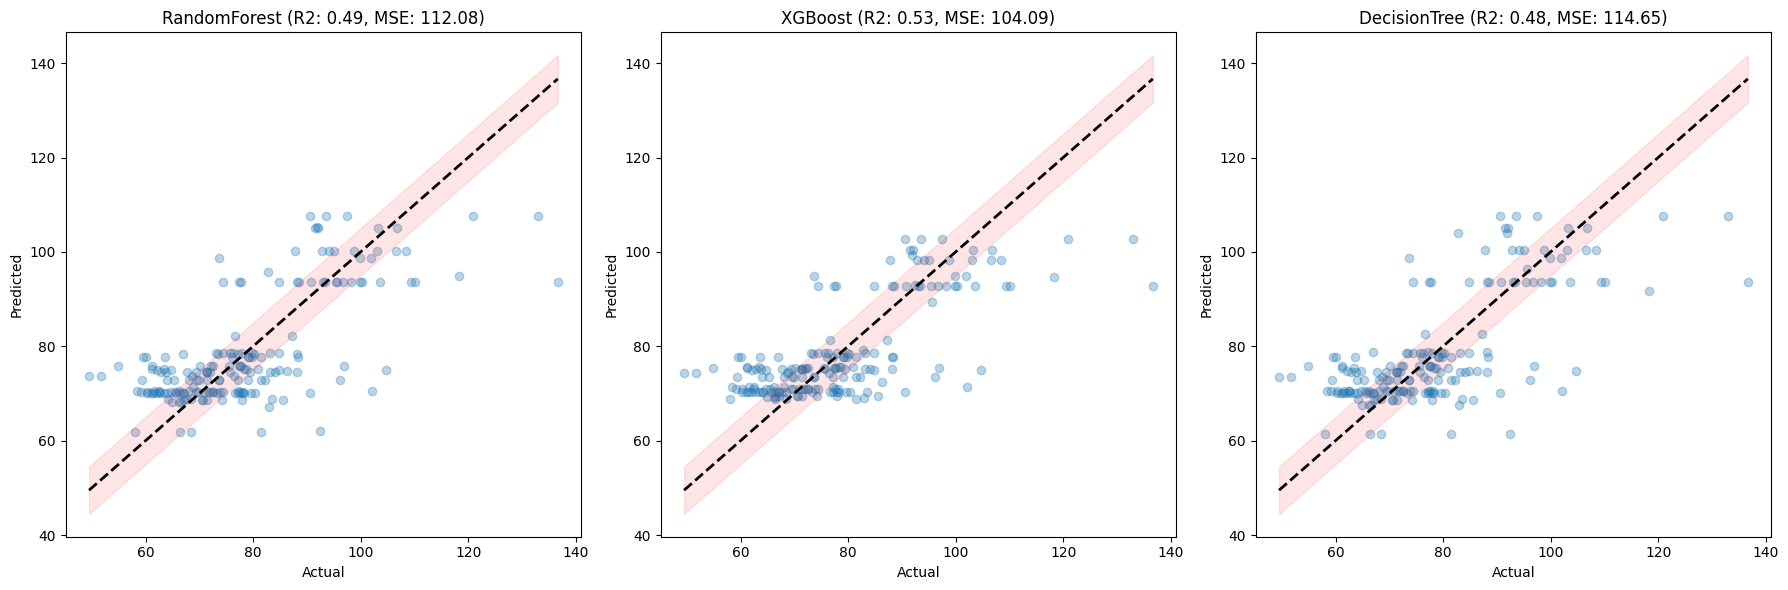

RandomForest - MSE: 112.08, R2: 0.49
XGBoost - MSE: 104.09, R2: 0.53
DecisionTree - MSE: 114.65, R2: 0.48


In [31]:

performance_metrics = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, pipeline) in enumerate(pipelines.items()):
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    performance_metrics[model_name] = {'MSE': mse, 'R2': r2}
    
    axes[idx].scatter(y_test, y_pred, alpha=0.3)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[idx].fill_between([y_test.min(), y_test.max()], [y_test.min() - 5, y_test.max() - 5], [y_test.min() + 5, y_test.max() + 5], color='r', alpha=0.1)
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].set_title(f'{model_name} (R2: {r2:.2f}, MSE: {mse:.2f})')

plt.tight_layout()
plt.show()

for model_name, metrics in performance_metrics.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.2f}, R2: {metrics['R2']:.2f}")

SHAP Summary for RandomForest:


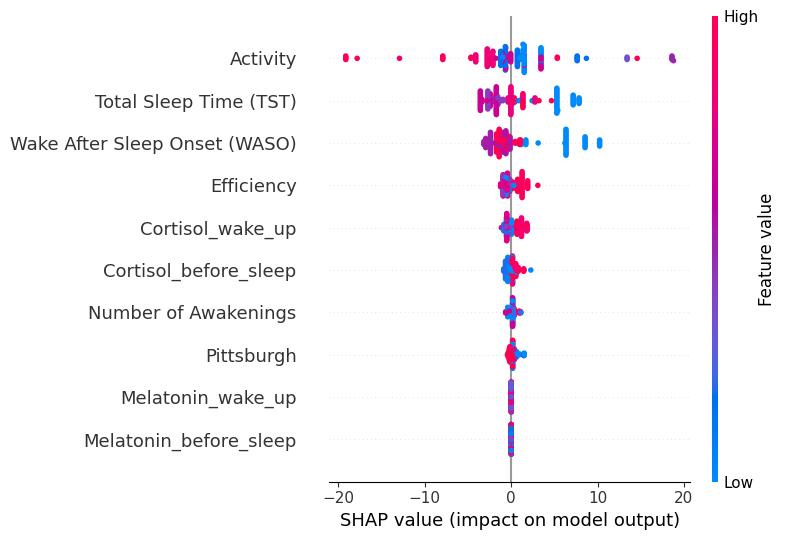

SHAP Summary for XGBoost:


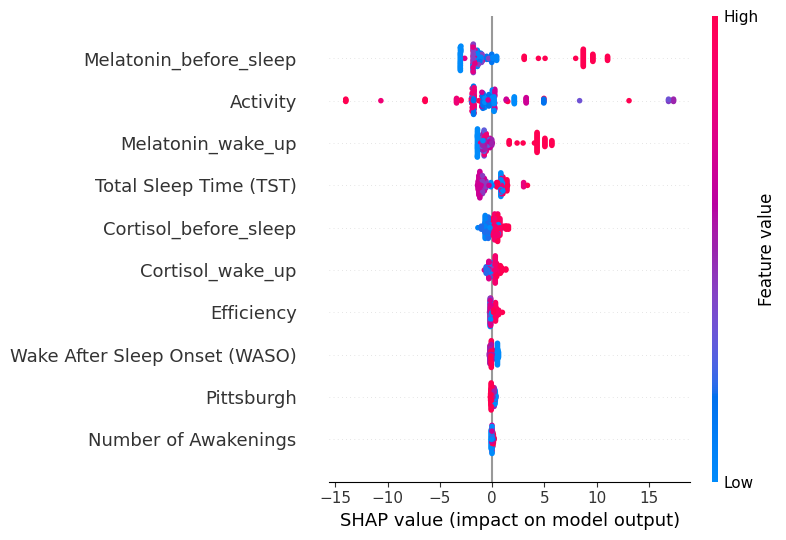

SHAP Summary for DecisionTree:


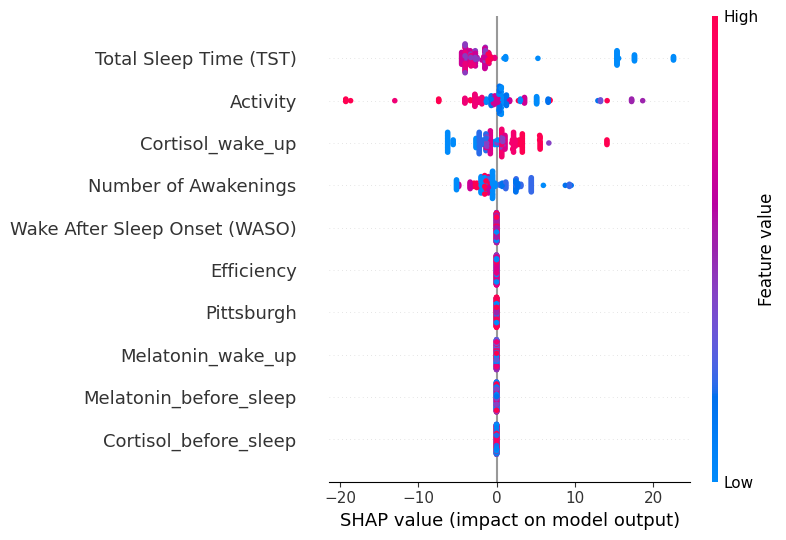

In [32]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    shap.summary_plot(shap_values, X_test)


SHAP Summary for RandomForest:


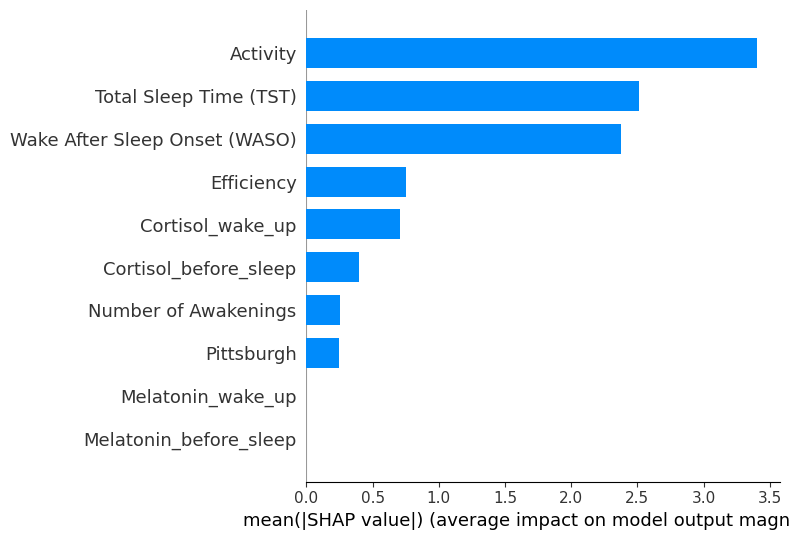

SHAP Summary for XGBoost:


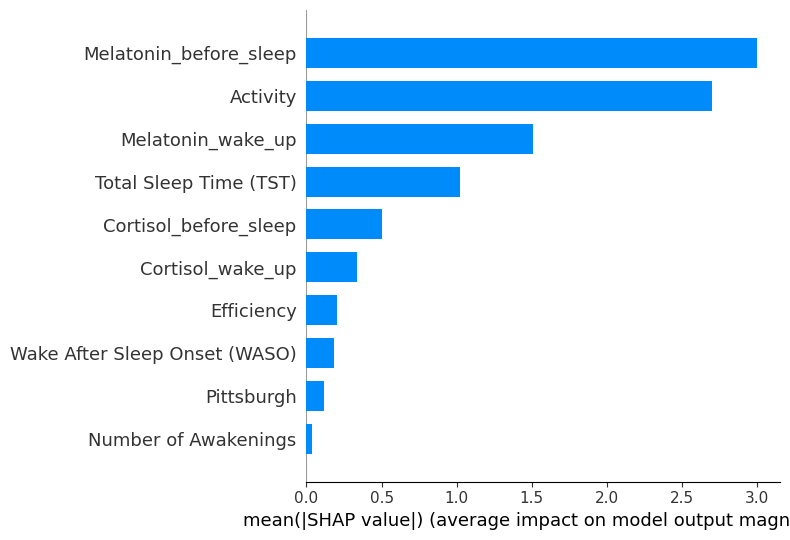

SHAP Summary for DecisionTree:


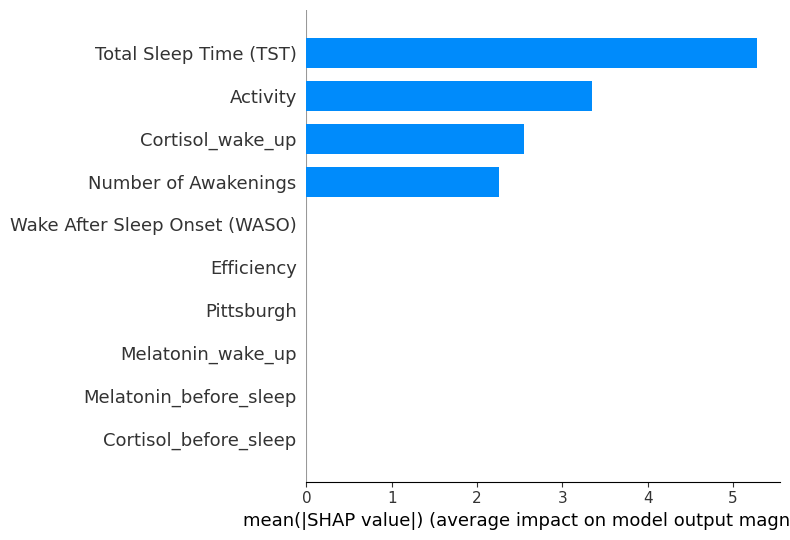

In [33]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    shap.summary_plot(shap_values, X_test, plot_type='bar')

In [68]:
shap.initjs()


In [78]:
shap_values_dict['RandomForest']

array([[-2.11765453,  0.15386947,  0.14714244, ...,  0.12626971,
         0.05893741, -0.0816322 ],
       [ 1.44143954, -0.18484884, -0.18945305, ..., -0.56856131,
         0.07856882,  0.21978887],
       [15.13330542,  0.03685853,  0.16540593, ...,  0.17167898,
         0.16962945, -0.22440889],
       ...,
       [-1.9745842 ,  0.28391379,  0.10372886, ...,  0.07394308,
         0.10831991, -0.09947508],
       [-1.94677198, -0.10605815, -0.32755999, ..., -0.50216558,
        -0.87905603, -0.78374328],
       [ 0.12333199,  0.05743608, -0.20350935, ..., -0.11330188,
         0.4545049 ,  0.27958909]])

In [79]:
shap.force_plot(explainers['RandomForest'].expected_value, shap_values_dict['RandomForest'][0], X_test.iloc[0])

In [80]:
shap.force_plot(explainers['XGBoost'].expected_value,
                shap_values_dict['XGBoost'][0], X_test.iloc[0])

In [81]:
predictions_df = pd.DataFrame({
    'Actual': y_test
})

for model_name, pipeline in pipelines.items():
    predictions_df[model_name] = pipeline.predict(X_test)

predictions_df.head()

,Actual,RandomForest,XGBoost,DecisionTree
720,75.093867,90.775835,91.786774,90.687528
721,67.039106,71.467454,71.848236,71.467983
722,86.830680,95.184213,94.162720,94.954876
723,103.092784,77.349463,76.574036,77.489245
724,73.170732,77.371109,77.139008,77.274728


In [83]:
predictions_df['Actual'].mean()

78.43853881600344

In [84]:
predictions_df['RandomForest'].mean()

78.81084043625954

In [85]:
predictions_df['XGBoost'].mean()

78.67665

In [86]:
predictions_df['DecisionTree'].mean()

78.79545363563452

In [90]:
predictions_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Actual,180.0,78.438539,13.441213,50.675676,68.767976,76.824584,86.736572,150.000000
RandomForest,180.0,78.810840,9.863000,68.489636,71.467454,75.653532,86.615341,112.768521
XGBoost,180.0,78.676651,9.445330,68.714203,71.848236,74.165878,85.665329,113.692642
DecisionTree,180.0,78.795454,9.851052,67.688066,71.467983,76.022028,85.889731,113.343852


# Task 2: Low state anxiety selected

In [91]:
X = low_state_anxiety_selected.drop(columns=['class', 'user', 'hr'])
y = low_state_anxiety_selected['hr']

In [92]:
X_train, X_test, y_train, y_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(y)*0.8)], y[int(len(y)*0.8):]

In [93]:
best_estimators_low = {}

for model_name, model in models.items():
    print(f"Performing grid search for {model_name}...")
    grid_search = GridSearchCV(
        pipelines[model_name], param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimators_low[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

for model_name, best_estimator in best_estimators_low.items():
    print(f"Training {model_name} with best parameters...")
    best_estimator.fit(X_train, y_train)
    pipelines[model_name] = best_estimator

    if model_name == 'XGBoost':
        explainer = shap.Explainer(best_estimator.named_steps['regressor'])
    else:
        explainer = shap.TreeExplainer(best_estimator.named_steps['regressor'])

    explainers[model_name] = explainer
    shap_values = explainer.shap_values(X_test)
    shap_values_dict[model_name] = shap_values

Performing grid search for RandomForest...
Best parameters for RandomForest: {'regressor__max_depth': 30, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
Performing grid search for XGBoost...
Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Performing grid search for DecisionTree...
Best parameters for DecisionTree: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10}
Training RandomForest with best parameters...
Training XGBoost with best parameters...
Training DecisionTree with best parameters...


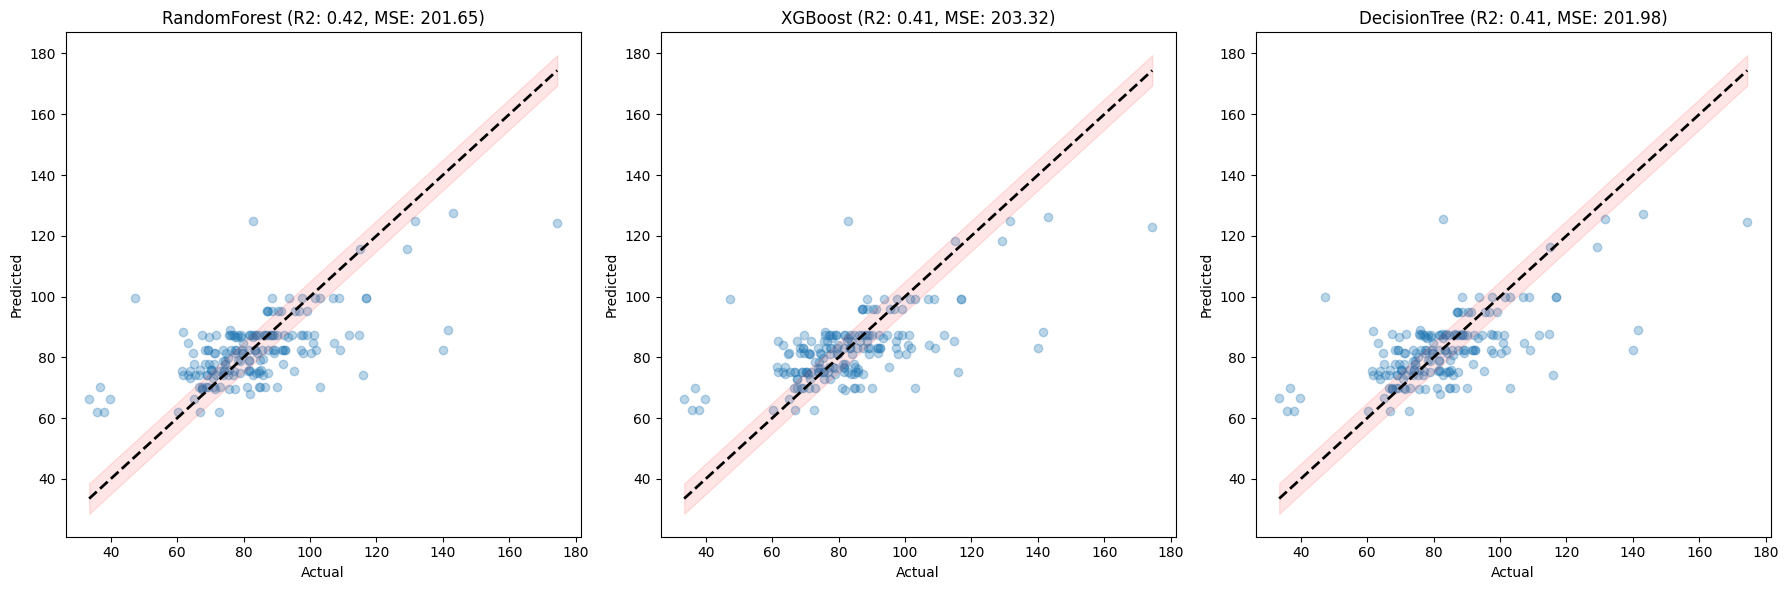

RandomForest - MSE: 201.65, R2: 0.42
XGBoost - MSE: 203.32, R2: 0.41
DecisionTree - MSE: 201.98, R2: 0.41


In [96]:
from sklearn.metrics import mean_squared_error, r2_score

performance_metrics = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, pipeline) in enumerate(pipelines.items()):
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    performance_metrics[model_name] = {'MSE': mse, 'R2': r2}

    axes[idx].scatter(y_test, y_pred, alpha=0.3)
    axes[idx].plot([y_test.min(), y_test.max()], [
                   y_test.min(), y_test.max()], 'k--', lw=2)
    axes[idx].fill_between([y_test.min(), y_test.max()], [y_test.min(
    ) - 5, y_test.max() - 5], [y_test.min() + 5, y_test.max() + 5], color='r', alpha=0.1)
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].set_title(f'{model_name} (R2: {r2:.2f}, MSE: {mse:.2f})')

plt.tight_layout()
plt.show()

for model_name, metrics in performance_metrics.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.2f}, R2: {metrics['R2']:.2f}")

SHAP Summary for RandomForest:


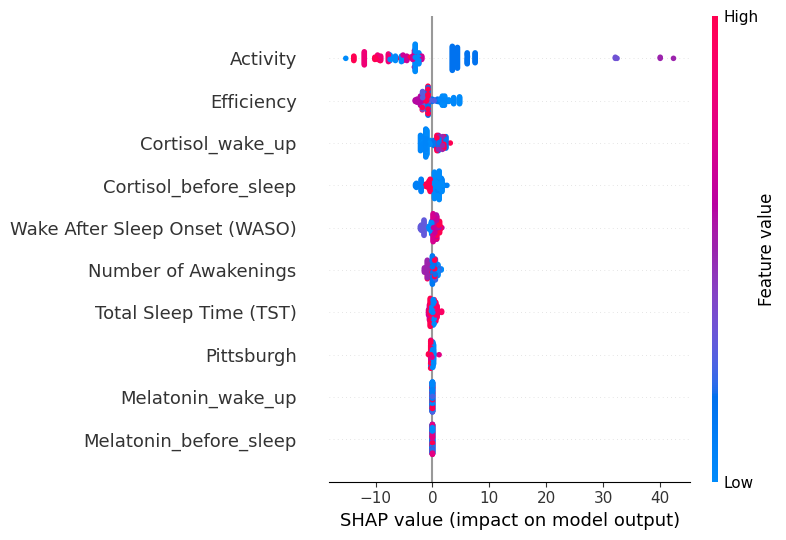

SHAP Summary for XGBoost:


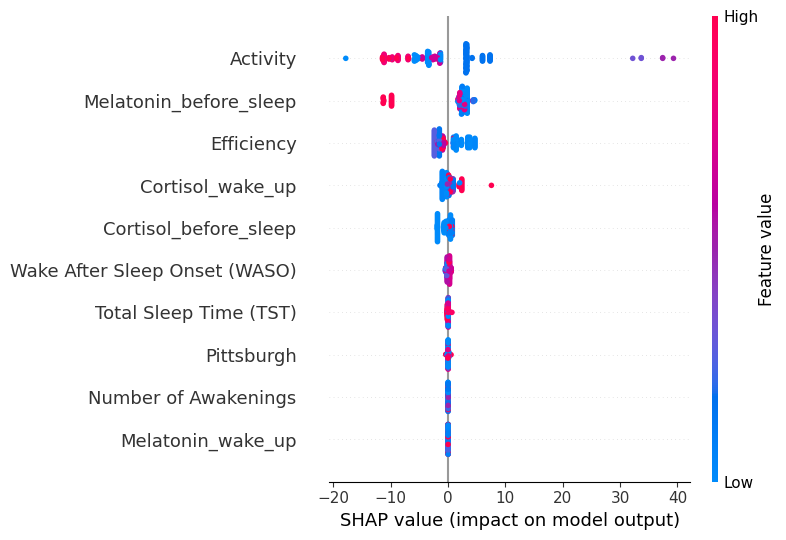

SHAP Summary for DecisionTree:


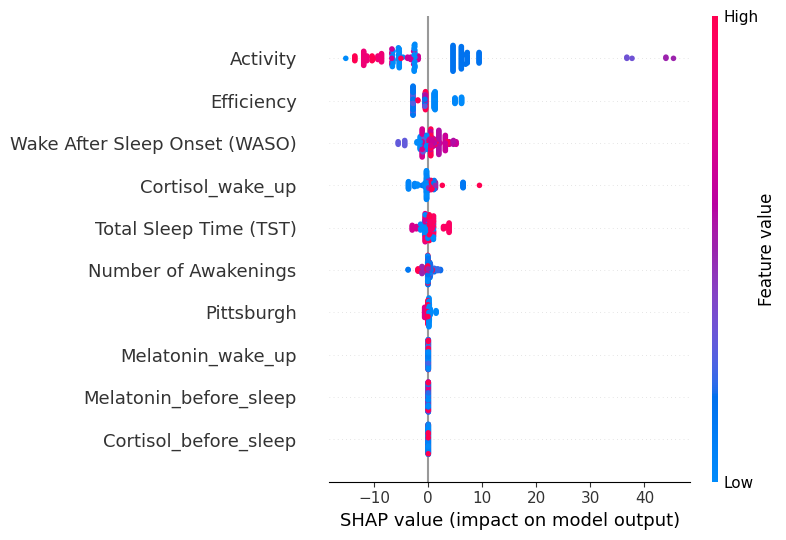

In [97]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    shap.summary_plot(shap_values, X_test)

In [98]:
shap.force_plot(explainers['RandomForest'].expected_value,
                shap_values_dict['RandomForest'][0], X_test.iloc[0])

In [99]:
shap.force_plot(explainers['XGBoost'].expected_value,
                shap_values_dict['XGBoost'][0], X_test.iloc[0])

In [100]:
predictions_df = pd.DataFrame({
    'Actual': y_test
})

for model_name, pipeline in pipelines.items():
    predictions_df[model_name] = pipeline.predict(X_test)

predictions_df.head()

,Actual,RandomForest,XGBoost,DecisionTree
720,61.919505,74.227927,75.051331,74.152921
721,88.626292,99.602204,99.132088,99.994316
722,66.445183,70.096926,69.993004,70.007676
723,36.674817,70.096926,69.993004,70.007676
724,100.840336,84.711184,83.946053,84.677206


In [102]:
predictions_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Actual,180.0,82.939268,18.622644,33.538290,71.684894,81.688261,89.955022,174.418605
RandomForest,180.0,82.456439,11.374382,62.018422,74.981106,82.524869,87.508197,127.509555
XGBoost,180.0,82.616875,11.172253,62.634151,75.051331,83.172470,87.322662,126.100983
DecisionTree,180.0,82.515615,11.434685,62.318256,75.170951,82.569140,87.529539,127.253757
